# Classification of fixed size paragraph vectors using LSTM
should be able to deal with all levels using the PARTS_LEVEL param

In [1]:
import json
import nltk
from nltk.tokenize import RegexpTokenizer
import string
import math
import os
import time
from collections import namedtuple, defaultdict
import cPickle as pickle
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import random

from multiprocessing.dummy import Pool as ThreadPool
import itertools

from sklearn.metrics import coverage_error
import sklearn.metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn import linear_model
from sklearn.preprocessing import MultiLabelBinarizer

from gensim.models.doc2vec import Doc2Vec, LabeledSentence

import logging
from logging import info
from functools import partial

import seaborn

import keras
from keras.layers import Input, Dense, Dropout, Masking
from keras.models import Model, Sequential
from keras.layers import Input, Masking
from keras.layers.convolutional import MaxPooling1D, Convolution1D
from keras.layers.pooling import GlobalAveragePooling1D
from keras.layers.recurrent import LSTM

from sklearn.model_selection import ParameterSampler

from thesis.utils.metrics import *
from thesis.utils.file import *

Using Theano backend.
Using gpu device 0: TITAN X (Pascal) (CNMeM is disabled, cuDNN 5105)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


# Global variables used throughout the script

In [2]:
root = logging.getLogger()
for handler in root.handlers[:]:
    root.removeHandler(handler)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) # adds a default StreamHanlder
#root.addHandler(logging.StreamHandler())

In [3]:
SVM_SEED = 1234
DOC2VEC_SEED = 1234
WORD2VEC_SEED = 1234
NN_SEED = 1234

In [4]:
NUM_CORES = 16

In [5]:
GLOBAL_VARS = namedtuple('GLOBAL_VARS', ['MODEL_NAME', 'DOC2VEC_MODEL_NAME', 'DOC2VEC_MODEL', 
                                         'SVM_MODEL_NAME', 'NN_MODEL_NAME'])

In [6]:
VOCAB_MODEL = "vocab_model"
MODEL_PREFIX = "model"
VALIDATION_MATRIX = "validation_matrix.pkl"
VALIDATION_DICT = "validation_dict.pkl"
TEST_MATRIX = "test_matrix.pkl"
TEST_DICT = "test_dict.pkl"
METRICS = "metrics.pkl"
CLASSIFIER = "classifier.pkl"
TYPE_CLASSIFIER= "{}_classifier.pkl"

TRAINING_DATA_MATRIX = "X_level_{}.npy"
TRAINING_LABELS_MATRIX = "y_{}.npy"
VALIDATION_DATA_MATRIX = "Xv_level_{}.npy"
VALIDATION_LABELS_MATRIX = "yv_{}.npy"
TEST_DATA_MATRIX = "Xt_level_{}.npy"
TEST_LABELS_MATRIX = "yt_{}.npy"

In [7]:
NN_PARAMETER_SEARCH_PREFIX = "lstm_{}_level_{}_batch_{}_nn_parameter_searches.pkl"

In [8]:
root_location = "/mnt/data2/shalaby/"
big_data_location = "/mnt/data/shalaby/"

matrices_save_location = big_data_location + "extended_pv_matrices/"
# matrices_save_location = big_data_location + "extended_pv_matrices/one_model/"
exports_location = root_location + "exported_data/"

nn_parameter_search_location = os.path.join(root_location, "nn_parameter_search_extended_abs_desc_claims_full_chunks")

doc_classifications_map_file = exports_location + "doc_classification_map.pkl"
sections_file = exports_location + "sections.pkl"
classes_file = exports_location + "classes.pkl"
subclasses_file = exports_location + "subclasses.pkl"
valid_classes_file = exports_location + "valid_classes.pkl"
valid_subclasses_file = exports_location + "valid_subclasses.pkl"
classifications_output = exports_location + "classifications.pkl"
training_docs_list_file = exports_location + "training_docs_list.pkl"
validation_docs_list_file = exports_location + "validation_docs_list.pkl"
test_docs_list_file = exports_location + "test_docs_list.pkl"

# Load general data required for classification

In [9]:
%%time
sections = pickle.load(open(sections_file))
classes = pickle.load(open(classes_file))
subclasses = pickle.load(open(subclasses_file))
valid_classes = pickle.load(open(valid_classes_file))
valid_subclasses = pickle.load(open(valid_subclasses_file))
training_docs_list = pickle.load(open(training_docs_list_file))
validation_docs_list = pickle.load(open(validation_docs_list_file))
test_docs_list = pickle.load(open(test_docs_list_file))

CPU times: user 2.58 s, sys: 104 ms, total: 2.68 s
Wall time: 2.68 s


In [10]:
len(training_docs_list)

1286325

In [11]:
len(validation_docs_list)

321473

In [12]:
len(test_docs_list)

401877

# Utility Functions for data loading

In [13]:
def get_training_data(classifications_type, level):
    info("Loading Training Data from file")
    training_data = np.load(open(os.path.join(matrices_save_location, GLOBAL_VARS.MODEL_NAME, 
                                              TRAINING_DATA_MATRIX.format(level))))
    training_labels = np.load(open(os.path.join(matrices_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                TRAINING_LABELS_MATRIX.format(classifications_type))))
    return training_data, training_labels

def get_validation_data(classifications_type, level):
    info("Loading Validation Data from file")
    validation_data = np.load(open(os.path.join(matrices_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                VALIDATION_DATA_MATRIX.format(level))))
    validation_labels = np.load(open(os.path.join(matrices_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                  VALIDATION_LABELS_MATRIX.format(classifications_type))))
    return validation_data, validation_labels

def get_test_data(classifications_type, level):
    info("Loading Test Data from file")
    test_data = np.load(open(os.path.join(matrices_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                TEST_DATA_MATRIX.format(level))))
    test_labels = np.load(open(os.path.join(matrices_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                  TEST_LABELS_MATRIX.format(classifications_type))))
    return test_data, test_labels

In [14]:
class MetricsCallback(keras.callbacks.Callback):
    """
    Callback called by keras after each epoch. Records the best validation loss and periodically checks the 
    validation metrics
    """
    def __init__(self):
        MetricsCallback.EPOCHS_BEFORE_VALIDATION = epochs_before_validation[classifications_type]
        MetricsCallback.GRAPH_MIN = metrics_graph_ranges[classifications_type]['min']
        MetricsCallback.GRAPH_MAX = metrics_graph_ranges[classifications_type]['max']
    
    def on_train_begin(self, logs={}):
        self.epoch_index = 0
        self.val_loss_reductions = 0
        self.metrics_dict = {}
        self.best_val_loss = np.iinfo(np.int32).max
        self.best_weights = None
        self.best_validation_metrics = None
        
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure(figsize=(12,6), dpi=80)
        self.ax = plt.subplot(111)
    def on_epoch_end(self, epoch, logs={}):
        self.epoch_index += 1
        self.losses.append(logs['loss'])
        self.val_losses.append(logs['val_loss'])
        loss_line, = self.ax.plot(range(1,self.epoch_index+1), self.losses, 'g-', label='Training Loss')
        val_loss_line, = self.ax.plot(range(1,self.epoch_index+1), self.val_losses, 'r-', label='Validation Loss')
        self.ax.legend(handles=[loss_line, val_loss_line])
        self.ax.set_ylim((MetricsCallback.GRAPH_MIN, MetricsCallback.GRAPH_MAX))
        self.fig.canvas.draw()
        if logs['val_loss'] < self.best_val_loss:
            self.val_loss_reductions += 1
            self.best_val_loss = logs['val_loss']
            self.best_weights = self.model.get_weights()
            print '\r    \r' # to remove the previous line of verbose output of model fit
            #time.sleep(0.1)
            info('Found lower val loss for epoch {} => {}'.format(self.epoch_index, round(logs['val_loss'], 5)))
            if self.val_loss_reductions % MetricsCallback.EPOCHS_BEFORE_VALIDATION == 0:
                
                info('Validation Loss Reduced {} times'.format(self.val_loss_reductions))
                info('Evaluating on Validation Data')
                yvp = self.model.predict(Xv)
                yvp_binary = get_binary_0_5(yvp)
                info('Generating Validation Metrics')
                validation_metrics = get_metrics(yv, yvp, yvp_binary)
                print "****** Validation Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
                    validation_metrics['coverage_error'], validation_metrics['top_3'], validation_metrics['top_5'], 
                    validation_metrics['f1_micro'], validation_metrics['f1_macro'])
                self.metrics_dict[self.epoch_index] = validation_metrics
#                 self.best_validation_metrics = validation_metrics

In [15]:
def create_keras_rnn_model(input_size, output_size, lstm_output_size, w_dropout_do, u_dropout_do, 
                           stack_layers=1, conv_size=None, conv_filter_length=3, max_pooling_length=None):
    
    model= Sequential()
#     model.add(Masking(mask_value=0., input_shape=(MAX_SIZE, input_size)))
    if conv_size:
        model.add(Convolution1D(nb_filter=conv_size, input_shape=(MAX_SIZE, input_size), filter_length=conv_filter_length, 
                                border_mode='same', activation='relu'))
        if max_pooling_length is not None:
            model.add(MaxPooling1D(pool_length=max_pooling_length))
    for i in range(stack_layers):
        model.add(LSTM(lstm_output_size, input_dim=input_size, dropout_W=w_dropout_do, dropout_U=u_dropout_do,
                       return_sequences=False if i+1 == stack_layers else True,
                  name='lstm_{}_w-drop_{}_u-drop_{}_layer_{}'.format(lstm_output_size, str(u_dropout_do), str(w_dropout_do), str(i+1))))
    model.add(Dense(output_size, activation='sigmoid', name='sigmoid_output'))
    model.compile(optimizer=NN_OPTIMIZER, loss='binary_crossentropy')
    return model

# Global Param Loop

In [16]:
# minimum change in val_loss from previous epoch to register as a decrease
early_stopper_deltas = {
    'sections': 0.00001,
    'classes': 0.00001,
    'subclasses': 0.00001
}
# how many epochs to wait when there is no decrease in val_loss before early stopping
early_stopper_patience = {
    'sections': 15,
    'classes': 15,
    'subclasses': 15
}
# number of epochs after which we do periodic evaluation of validation metrics
epochs_before_validation = {
    'sections': 10,
    'classes': 20,
    'subclasses': 20
}

# ranges for learning graph shown
metrics_graph_ranges = {
    'sections': {'min':0, 'max': 0.3},
    'classes': {'min':0, 'max': 0.05},
    'subclasses': {'min':0, 'max': 0.05}
}

In [17]:
LEVEL_DOC = 1
LEVEL_DIVISIONS = 2
LEVEL_CHUNKS = 3

In [18]:
DOC2VEC_SIZE = 200
DOC2VEC_WINDOW = 2
DOC2VEC_MAX_VOCAB_SIZE = None
DOC2VEC_SAMPLE = 1e-3
DOC2VEC_TYPE = 1
DOC2VEC_HIERARCHICAL_SAMPLE = 0
DOC2VEC_NEGATIVE_SAMPLE_SIZE = 10
DOC2VEC_CONCAT = 0
DOC2VEC_MEAN = 1
DOC2VEC_TRAIN_WORDS = 0
DOC2VEC_EPOCHS = 1 # we do our training manually one epoch at a time
DOC2VEC_MAX_EPOCHS = 8
REPORT_DELAY = 20 # report the progress every x seconds
REPORT_VOCAB_PROGRESS = 100000 # report vocab progress every x documents

DOC2VEC_EPOCH = 8

In [19]:
GLOBAL_PARMS_TO_RUN = [
    {
        'doc2vec_epoch': DOC2VEC_EPOCH,
        'classifications': sections,
        'classifications_type': 'sections',
        'parts_level': LEVEL_DOC,
        'nn_batch_size': 4096,
        'lstm_output_size': 1000,
        'lstm_w_dropout': 0.5,
        'lstm_u_dropout': 0.5,
        'lstm_stack_layers': 3,
        'lstm_conv_size': None,
        'lstm_conv_filter_length': None,
        'lstm_max_pooling_length': None
    },
    {
        'doc2vec_epoch': DOC2VEC_EPOCH,
        'classifications': sections,
        'classifications_type': 'sections',
        'parts_level': LEVEL_DIVISIONS,
        'nn_batch_size': 4096,
        'lstm_output_size': 1000,
        'lstm_w_dropout': 0.5,
        'lstm_u_dropout': 0.5,
        'lstm_stack_layers': 3,
        'lstm_conv_size': None,
        'lstm_conv_filter_length': None,
        'lstm_max_pooling_length': None
    }
]


==================================== NEW PARAM SET ============================================
{'lstm_conv_filter_length': None, 'lstm_stack_layers': 3, 'nn_batch_size': 4096, 'classifications_type': 'sections', 'lstm_w_dropout': 0.5, 'lstm_max_pooling_length': None, 'lstm_u_dropout': 0.5, 'parts_level': 1, 'lstm_output_size': 1000, 'doc2vec_epoch': 8, 'lstm_conv_size': None}
doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8


2017-04-18 02:55:27,713 : INFO : Loading Training Documents
2017-04-18 02:55:27,714 : INFO : Loading Training Data from file
2017-04-18 02:55:34,701 : INFO : Loading Validation Documents
2017-04-18 02:55:34,703 : INFO : Loading Validation Data from file


(1286325, 1, 200)
(1286325, 8)


2017-04-18 02:55:36,469 : INFO : Loading Previous results from /mnt/data2/shalaby/nn_parameter_search_extended_abs_desc_claims_full_chunks/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/lstm_sections_level_1_batch_4096_nn_parameter_searches.pkl


(321473, 1, 200)
(321473, 8)


2017-04-18 02:55:44,794 : INFO : ***************************************************************************************
2017-04-18 02:55:44,796 : INFO : lstm_optimizer_rmsprop_size_1000_w-drop_0.5_u-drop_0.5_stack_3_conv_None


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_1000_w-drop_0.5_u-drop_0.5_ (None, None, 1000)    4804000     lstm_input_1[0][0]               
____________________________________________________________________________________________________
lstm_1000_w-drop_0.5_u-drop_0.5_ (None, None, 1000)    8004000     lstm_1000_w-drop_0.5_u-drop_0.5_l
____________________________________________________________________________________________________
lstm_1000_w-drop_0.5_u-drop_0.5_ (None, 1000)          8004000     lstm_1000_w-drop_0.5_u-drop_0.5_l
____________________________________________________________________________________________________
sigmoid_output (Dense)           (None, 8)             8008        lstm_1000_w-drop_0.5_u-drop_0.5_l
Total params: 20,820,008
Trainable params: 20,820,008
Non-trainable params: 0
_____________

<IPython.core.display.Javascript object>


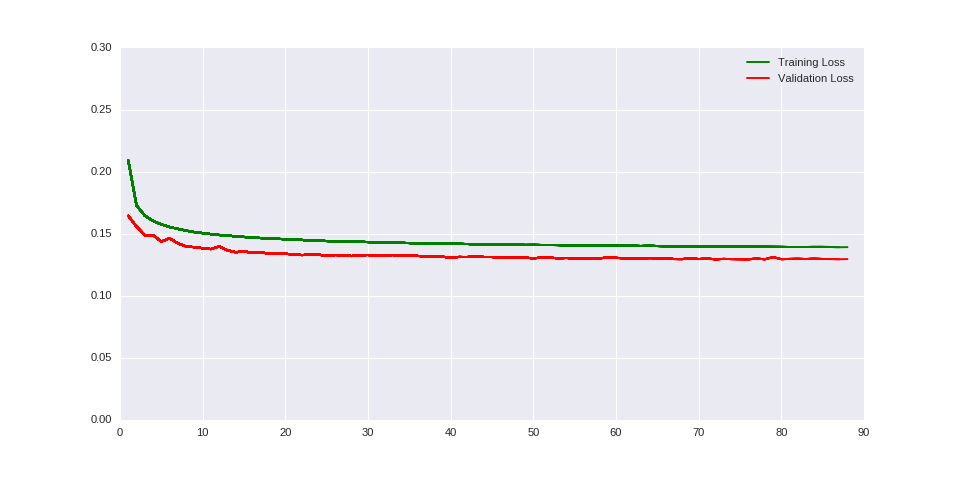

Epoch 1/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.2093

2017-04-18 02:59:41,570 : INFO : Found lower val loss for epoch 1 => 0.16466


    
1286325/1286325 [==============================] - 168s - loss: 0.2093 - val_loss: 0.1647
Epoch 2/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1730

2017-04-18 03:02:41,977 : INFO : Found lower val loss for epoch 2 => 0.15595


    
1286325/1286325 [==============================] - 180s - loss: 0.1730 - val_loss: 0.1559
Epoch 3/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1648

2017-04-18 03:06:14,675 : INFO : Found lower val loss for epoch 3 => 0.14905


    
1286325/1286325 [==============================] - 212s - loss: 0.1648 - val_loss: 0.1491
Epoch 4/200
1286325/1286325 [==============================] - 247s - loss: 0.1605 - val_loss: 0.1491
Epoch 5/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1577

2017-04-18 03:14:08,313 : INFO : Found lower val loss for epoch 5 => 0.14384


    
1286325/1286325 [==============================] - 226s - loss: 0.1577 - val_loss: 0.1438
Epoch 6/200
1286325/1286325 [==============================] - 178s - loss: 0.1557 - val_loss: 0.1466
Epoch 7/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1541

2017-04-18 03:20:13,546 : INFO : Found lower val loss for epoch 7 => 0.14248


    
1286325/1286325 [==============================] - 186s - loss: 0.1541 - val_loss: 0.1425
Epoch 8/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1527

2017-04-18 03:23:16,027 : INFO : Found lower val loss for epoch 8 => 0.13996


    
1286325/1286325 [==============================] - 182s - loss: 0.1527 - val_loss: 0.1400
Epoch 9/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1515

2017-04-18 03:26:21,000 : INFO : Found lower val loss for epoch 9 => 0.13939


    
1286325/1286325 [==============================] - 184s - loss: 0.1515 - val_loss: 0.1394
Epoch 10/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1507

2017-04-18 03:29:25,102 : INFO : Found lower val loss for epoch 10 => 0.13852


    
1286325/1286325 [==============================] - 184s - loss: 0.1507 - val_loss: 0.1385
Epoch 11/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1499

2017-04-18 03:32:30,280 : INFO : Found lower val loss for epoch 11 => 0.13785


    
1286325/1286325 [==============================] - 185s - loss: 0.1499 - val_loss: 0.1379
Epoch 12/200
1286325/1286325 [==============================] - 185s - loss: 0.1492 - val_loss: 0.1401
Epoch 13/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1487

2017-04-18 03:38:40,588 : INFO : Found lower val loss for epoch 13 => 0.13686
2017-04-18 03:38:40,590 : INFO : Validation Loss Reduced 10 times
2017-04-18 03:38:40,591 : INFO : Evaluating on Validation Data


2017-04-18 03:41:02,626 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.417 | Top 3: 0.975 | Top 5: 0.996 | F1 Micro: 0.792 | F1 Macro: 0.732
1286325/1286325 [==============================] - 335s - loss: 0.1487 - val_loss: 0.1369
Epoch 14/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1481

2017-04-18 03:43:58,275 : INFO : Found lower val loss for epoch 14 => 0.13529


    
1286325/1286325 [==============================] - 167s - loss: 0.1481 - val_loss: 0.1353
Epoch 15/200
1286325/1286325 [==============================] - 165s - loss: 0.1476 - val_loss: 0.1361
Epoch 16/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1471

2017-04-18 03:49:29,842 : INFO : Found lower val loss for epoch 16 => 0.1347


    
1286325/1286325 [==============================] - 166s - loss: 0.1471 - val_loss: 0.1347
Epoch 17/200
1286325/1286325 [==============================] - 166s - loss: 0.1468 - val_loss: 0.1351
Epoch 18/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1464

2017-04-18 03:55:01,714 : INFO : Found lower val loss for epoch 18 => 0.13426


    
1286325/1286325 [==============================] - 165s - loss: 0.1464 - val_loss: 0.1343
Epoch 19/200
1286325/1286325 [==============================] - 165s - loss: 0.1461 - val_loss: 0.1346
Epoch 20/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1458

2017-04-18 04:00:36,376 : INFO : Found lower val loss for epoch 20 => 0.13404


    
1286325/1286325 [==============================] - 168s - loss: 0.1458 - val_loss: 0.1340
Epoch 21/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1454

2017-04-18 04:03:21,979 : INFO : Found lower val loss for epoch 21 => 0.13352


    
1286325/1286325 [==============================] - 165s - loss: 0.1454 - val_loss: 0.1335
Epoch 22/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1452

2017-04-18 04:06:07,709 : INFO : Found lower val loss for epoch 22 => 0.13302


    
1286325/1286325 [==============================] - 165s - loss: 0.1452 - val_loss: 0.1330
Epoch 23/200
1286325/1286325 [==============================] - 165s - loss: 0.1447 - val_loss: 0.1333
Epoch 24/200
1286325/1286325 [==============================] - 166s - loss: 0.1446 - val_loss: 0.1333
Epoch 25/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1443

2017-04-18 04:14:24,216 : INFO : Found lower val loss for epoch 25 => 0.13247


    
1286325/1286325 [==============================] - 165s - loss: 0.1443 - val_loss: 0.1325
Epoch 26/200
1286325/1286325 [==============================] - 176s - loss: 0.1442 - val_loss: 0.1330
Epoch 27/200
1286325/1286325 [==============================] - 186s - loss: 0.1440 - val_loss: 0.1329
Epoch 28/200
1286325/1286325 [==============================] - 190s - loss: 0.1433 - val_loss: 0.1326
Epoch 32/200
1286325/1286325 [==============================] - 187s - loss: 0.1432 - val_loss: 0.1323
Epoch 33/200
1286325/1286325 [==============================] - 191s - loss: 0.1430 - val_loss: 0.1331
Epoch 34/200
1286325/1286325 [==============================] - 189s - loss: 0.1428 - val_loss: 0.1324
Epoch 35/200
1286325/1286325 [==============================] - 185s - loss: 0.1427 - val_loss: 0.1330
Epoch 36/200
1286325/1286325 [==============================] - 189s - loss: 0.1425 - val_loss: 0.1323
Epoch 37/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0

2017-04-18 04:51:54,684 : INFO : Found lower val loss for epoch 37 => 0.132


    
1286325/1286325 [==============================] - 189s - loss: 0.1424 - val_loss: 0.1320
Epoch 38/200
1286325/1286325 [==============================] - 182s - loss: 0.1424 - val_loss: 0.1320
Epoch 39/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1421

2017-04-18 04:58:16,013 : INFO : Found lower val loss for epoch 39 => 0.13165
2017-04-18 04:58:16,015 : INFO : Validation Loss Reduced 20 times
2017-04-18 04:58:16,016 : INFO : Evaluating on Validation Data


2017-04-18 05:00:42,717 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.400 | Top 3: 0.977 | Top 5: 0.996 | F1 Micro: 0.803 | F1 Macro: 0.753
1286325/1286325 [==============================] - 353s - loss: 0.1421 - val_loss: 0.1317
Epoch 40/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1421

2017-04-18 05:04:10,188 : INFO : Found lower val loss for epoch 40 => 0.13095


    
1286325/1286325 [==============================] - 199s - loss: 0.1421 - val_loss: 0.1309
Epoch 41/200
1286325/1286325 [==============================] - 205s - loss: 0.1420 - val_loss: 0.1315
Epoch 42/200
1286325/1286325 [==============================] - 234s - loss: 0.1419 - val_loss: 0.1314
Epoch 43/200
1286325/1286325 [==============================] - 208s - loss: 0.1418 - val_loss: 0.1321
Epoch 44/200
1286325/1286325 [==============================] - 203s - loss: 0.1418 - val_loss: 0.1315
Epoch 45/200
1286325/1286325 [==============================] - 205s - loss: 0.1415 - val_loss: 0.1314
Epoch 46/200
1286325/1286325 [==============================] - 203s - loss: 0.1416 - val_loss: 0.1310
Epoch 47/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1415

2017-04-18 05:28:38,661 : INFO : Found lower val loss for epoch 47 => 0.13069


    
1286325/1286325 [==============================] - 207s - loss: 0.1415 - val_loss: 0.1307
Epoch 48/200
1286325/1286325 [==============================] - 209s - loss: 0.1414 - val_loss: 0.1310
Epoch 49/200
1286325/1286325 [==============================] - 204s - loss: 0.1412 - val_loss: 0.1309
Epoch 50/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1412

2017-04-18 05:38:57,428 : INFO : Found lower val loss for epoch 50 => 0.13039


    
1286325/1286325 [==============================] - 204s - loss: 0.1412 - val_loss: 0.1304
Epoch 51/200
1286325/1286325 [==============================] - 205s - loss: 0.1411 - val_loss: 0.1310
Epoch 52/200
1286325/1286325 [==============================] - 204s - loss: 0.1411 - val_loss: 0.1309
Epoch 53/200
1286325/1286325 [==============================] - 203s - loss: 0.1411 - val_loss: 0.1304
Epoch 54/200
1286325/1286325 [==============================] - 205s - loss: 0.1408 - val_loss: 0.1307
Epoch 55/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1408

2017-04-18 05:55:59,386 : INFO : Found lower val loss for epoch 55 => 0.13031


    
1286325/1286325 [==============================] - 203s - loss: 0.1408 - val_loss: 0.1303
Epoch 56/200
1286325/1286325 [==============================] - 212s - loss: 0.1408 - val_loss: 0.1305
Epoch 57/200
1286325/1286325 [==============================] - 209s - loss: 0.1408 - val_loss: 0.1305
Epoch 58/200
1286325/1286325 [==============================] - 207s - loss: 0.1407 - val_loss: 0.1303
Epoch 59/200
1286325/1286325 [==============================] - 206s - loss: 0.1406 - val_loss: 0.1312
Epoch 60/200
1286325/1286325 [==============================] - 209s - loss: 0.1405 - val_loss: 0.1308
Epoch 61/200
1286325/1286325 [==============================] - 209s - loss: 0.1405 - val_loss: 0.1304
Epoch 62/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1405

2017-04-18 06:20:19,174 : INFO : Found lower val loss for epoch 62 => 0.13023


    
1286325/1286325 [==============================] - 204s - loss: 0.1405 - val_loss: 0.1302
Epoch 63/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1403

2017-04-18 06:23:42,704 : INFO : Found lower val loss for epoch 63 => 0.13005


    
1286325/1286325 [==============================] - 203s - loss: 0.1403 - val_loss: 0.1301
Epoch 64/200
1286325/1286325 [==============================] - 208s - loss: 0.1405 - val_loss: 0.1306
Epoch 65/200
1286325/1286325 [==============================] - 195s - loss: 0.1403 - val_loss: 0.1304
Epoch 66/200
1286325/1286325 [==============================] - 210s - loss: 0.1401 - val_loss: 0.1306
Epoch 67/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1402

2017-04-18 06:37:20,682 : INFO : Found lower val loss for epoch 67 => 0.12981


    
1286325/1286325 [==============================] - 203s - loss: 0.1402 - val_loss: 0.1298
Epoch 68/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1402

2017-04-18 06:40:47,755 : INFO : Found lower val loss for epoch 68 => 0.12977


    
1286325/1286325 [==============================] - 207s - loss: 0.1402 - val_loss: 0.1298
Epoch 69/200
1286325/1286325 [==============================] - 204s - loss: 0.1401 - val_loss: 0.1305
Epoch 70/200
1286325/1286325 [==============================] - 205s - loss: 0.1400 - val_loss: 0.1298
Epoch 71/200
1286325/1286325 [==============================] - 207s - loss: 0.1401 - val_loss: 0.1302
Epoch 72/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1399

2017-04-18 06:54:32,450 : INFO : Found lower val loss for epoch 72 => 0.12961


    
1286325/1286325 [==============================] - 206s - loss: 0.1399 - val_loss: 0.1296
Epoch 73/200
1286325/1286325 [==============================] - 204s - loss: 0.1398 - val_loss: 0.1299
Epoch 74/200
1286325/1286325 [==============================] - 207s - loss: 0.1399 - val_loss: 0.1298
Epoch 75/200
1286325/1286325 [==============================] - 204s - loss: 0.1399 - val_loss: 0.1297
Epoch 76/200
1286325/1286325 [==============================] - 204s - loss: 0.1399 - val_loss: 0.1296
Epoch 77/200
1286325/1286325 [==============================] - 208s - loss: 0.1398 - val_loss: 0.1302
Epoch 78/200
1286325/1286325 [==============================] - 206s - loss: 0.1398 - val_loss: 0.1296
Epoch 79/200
1286325/1286325 [==============================] - 204s - loss: 0.1397 - val_loss: 0.1314
Epoch 80/200
1286325/1286325 [==============================] - 227s - loss: 0.1396 - val_loss: 0.1297
Epoch 81/200
1286325/1286325 [==============================] - 220s - loss: 0.13

2017-04-18 07:49:53,872 : INFO : Evaluating on Validation Data using saved best weights
2017-04-18 07:52:22,174 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.393 | Top 3: 0.978 | Top 5: 0.997 | F1 Micro: 0.808 | F1 Macro: 0.760


2017-04-18 07:52:31,327 : INFO : Loading Previous results from /mnt/data2/shalaby/nn_parameter_search_extended_abs_desc_claims_full_chunks/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/lstm_sections_level_1_batch_4096_nn_parameter_searches.pkl


==================================== NEW PARAM SET ============================================
{'lstm_conv_filter_length': None, 'lstm_stack_layers': 3, 'nn_batch_size': 4096, 'classifications_type': 'classes', 'lstm_w_dropout': 0.5, 'lstm_max_pooling_length': None, 'lstm_u_dropout': 0.5, 'parts_level': 1, 'lstm_output_size': 1000, 'doc2vec_epoch': 8, 'lstm_conv_size': None}
doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8


2017-04-18 07:52:45,909 : INFO : Loading Training Documents
2017-04-18 07:52:45,911 : INFO : Loading Training Data from file
2017-04-18 07:52:48,737 : INFO : Loading Validation Documents
2017-04-18 07:52:48,739 : INFO : Loading Validation Data from file


(1286325, 1, 200)
(1286325, 244)


2017-04-18 07:52:49,455 : INFO : Loading Previous results from /mnt/data2/shalaby/nn_parameter_search_extended_abs_desc_claims_full_chunks/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/lstm_classes_level_1_batch_4096_nn_parameter_searches.pkl


(321473, 1, 200)
(321473, 244)


2017-04-18 07:52:56,787 : INFO : ***************************************************************************************
2017-04-18 07:52:56,789 : INFO : lstm_optimizer_rmsprop_size_1000_w-drop_0.5_u-drop_0.5_stack_3_conv_None


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_1000_w-drop_0.5_u-drop_0.5_ (None, None, 1000)    4804000     lstm_input_2[0][0]               
____________________________________________________________________________________________________
lstm_1000_w-drop_0.5_u-drop_0.5_ (None, None, 1000)    8004000     lstm_1000_w-drop_0.5_u-drop_0.5_l
____________________________________________________________________________________________________
lstm_1000_w-drop_0.5_u-drop_0.5_ (None, 1000)          8004000     lstm_1000_w-drop_0.5_u-drop_0.5_l
____________________________________________________________________________________________________
sigmoid_output (Dense)           (None, 244)           244244      lstm_1000_w-drop_0.5_u-drop_0.5_l
Total params: 21,056,244
Trainable params: 21,056,244
Non-trainable params: 0
_____________

<IPython.core.display.Javascript object>


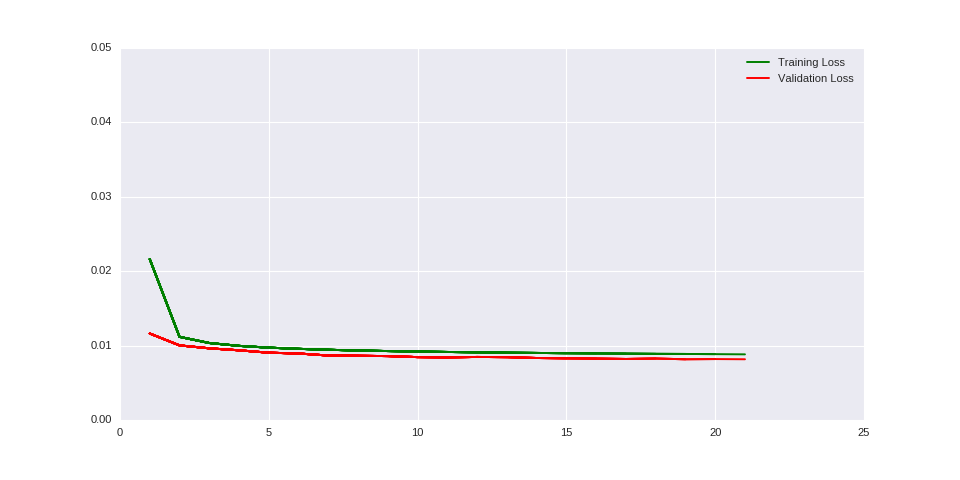

Epoch 1/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0216

2017-04-18 07:57:08,631 : INFO : Found lower val loss for epoch 1 => 0.01162


    
1286325/1286325 [==============================] - 190s - loss: 0.0216 - val_loss: 0.0116
Epoch 2/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0112

2017-04-18 08:00:32,201 : INFO : Found lower val loss for epoch 2 => 0.01003


    
1286325/1286325 [==============================] - 203s - loss: 0.0112 - val_loss: 0.0100
Epoch 3/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0103

2017-04-18 08:03:59,960 : INFO : Found lower val loss for epoch 3 => 0.00963


    
1286325/1286325 [==============================] - 207s - loss: 0.0103 - val_loss: 0.0096
Epoch 4/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0100

2017-04-18 08:07:29,437 : INFO : Found lower val loss for epoch 4 => 0.00937


    
1286325/1286325 [==============================] - 209s - loss: 0.0100 - val_loss: 0.0094
Epoch 5/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0097

2017-04-18 08:10:56,275 : INFO : Found lower val loss for epoch 5 => 0.00905


    
1286325/1286325 [==============================] - 206s - loss: 0.0097 - val_loss: 0.0090
Epoch 6/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0096

2017-04-18 08:14:20,891 : INFO : Found lower val loss for epoch 6 => 0.00894


    
1286325/1286325 [==============================] - 204s - loss: 0.0096 - val_loss: 0.0089
Epoch 7/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0094

2017-04-18 08:17:48,566 : INFO : Found lower val loss for epoch 7 => 0.00867


    
1286325/1286325 [==============================] - 207s - loss: 0.0094 - val_loss: 0.0087
Epoch 8/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0093

2017-04-18 08:21:16,015 : INFO : Found lower val loss for epoch 8 => 0.00863


    
1286325/1286325 [==============================] - 207s - loss: 0.0093 - val_loss: 0.0086
Epoch 9/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0093

2017-04-18 08:24:41,620 : INFO : Found lower val loss for epoch 9 => 0.00859


    
1286325/1286325 [==============================] - 205s - loss: 0.0093 - val_loss: 0.0086
Epoch 10/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0092

2017-04-18 08:28:09,044 : INFO : Found lower val loss for epoch 10 => 0.00845


    
1286325/1286325 [==============================] - 207s - loss: 0.0092 - val_loss: 0.0085
Epoch 11/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0091

2017-04-18 08:31:33,393 : INFO : Found lower val loss for epoch 11 => 0.00842


    
1286325/1286325 [==============================] - 204s - loss: 0.0091 - val_loss: 0.0084
Epoch 12/200
1286325/1286325 [==============================] - 201s - loss: 0.0091 - val_loss: 0.0085
Epoch 13/200
1286325/1286325 [==============================] - 205s - loss: 0.0091 - val_loss: 0.0084
Epoch 14/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0090

2017-04-18 08:41:44,758 : INFO : Found lower val loss for epoch 14 => 0.00833


    
1286325/1286325 [==============================] - 204s - loss: 0.0090 - val_loss: 0.0083
Epoch 15/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0090

2017-04-18 08:45:10,945 : INFO : Found lower val loss for epoch 15 => 0.00829


    
1286325/1286325 [==============================] - 206s - loss: 0.0090 - val_loss: 0.0083
Epoch 16/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0089

2017-04-18 08:48:30,631 : INFO : Found lower val loss for epoch 16 => 0.00826


    
1286325/1286325 [==============================] - 199s - loss: 0.0089 - val_loss: 0.0083
Epoch 17/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0089

2017-04-18 08:51:57,842 : INFO : Found lower val loss for epoch 17 => 0.0082


    
1286325/1286325 [==============================] - 207s - loss: 0.0089 - val_loss: 0.0082
Epoch 18/200
1286325/1286325 [==============================] - 200s - loss: 0.0089 - val_loss: 0.0083
Epoch 19/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0089

2017-04-18 08:58:46,582 : INFO : Found lower val loss for epoch 19 => 0.00816


    
1286325/1286325 [==============================] - 208s - loss: 0.0089 - val_loss: 0.0082
Epoch 20/200
1286325/1286325 [==============================] - 205s - loss: 0.0089 - val_loss: 0.0082
Epoch 21/200
1286325/1286325 [==============================] - 207s - loss: 0.0088 - val_loss: 0.0082
Epoch 22/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1433

2017-04-18 13:30:17,447 : INFO : Found lower val loss for epoch 4 => 0.14148


    
1286325/1286325 [==============================] - 384s - loss: 0.1433 - val_loss: 0.1415
Epoch 5/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1391

2017-04-18 13:36:32,306 : INFO : Found lower val loss for epoch 5 => 0.13442


    
1286325/1286325 [==============================] - 374s - loss: 0.1391 - val_loss: 0.1344
Epoch 6/200
1286325/1286325 [==============================] - 387s - loss: 0.1361 - val_loss: 0.1368
Epoch 7/200
1286325/1286325 [==============================] - 385s - loss: 0.1339 - val_loss: 0.1345
Epoch 8/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1320

2017-04-18 13:55:51,549 : INFO : Found lower val loss for epoch 8 => 0.13144


    
1286325/1286325 [==============================] - 385s - loss: 0.1320 - val_loss: 0.1314
Epoch 9/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1304

2017-04-18 14:02:15,614 : INFO : Found lower val loss for epoch 9 => 0.13016


    
1286325/1286325 [==============================] - 384s - loss: 0.1304 - val_loss: 0.1302
Epoch 10/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1293

2017-04-18 14:09:18,549 : INFO : Found lower val loss for epoch 10 => 0.12821


    
1286325/1286325 [==============================] - 422s - loss: 0.1293 - val_loss: 0.1282
Epoch 11/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1282

2017-04-18 14:15:34,744 : INFO : Found lower val loss for epoch 11 => 0.12817


    
1286325/1286325 [==============================] - 376s - loss: 0.1282 - val_loss: 0.1282
Epoch 12/200
1286325/1286325 [==============================] - 388s - loss: 0.1272 - val_loss: 0.1324
Epoch 13/200
1286325/1286325 [==============================] - 385s - loss: 0.1264 - val_loss: 0.1282
Epoch 14/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1255

2017-04-18 14:35:03,667 : INFO : Found lower val loss for epoch 14 => 0.12576
2017-04-18 14:35:03,668 : INFO : Validation Loss Reduced 10 times
2017-04-18 14:35:03,669 : INFO : Evaluating on Validation Data


2017-04-18 14:38:56,115 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.374 | Top 3: 0.980 | Top 5: 0.997 | F1 Micro: 0.815 | F1 Macro: 0.771
1286325/1286325 [==============================] - 635s - loss: 0.1254 - val_loss: 0.1258
Epoch 15/200
1286325/1286325 [==============================] - 395s - loss: 0.1249 - val_loss: 0.1267
Epoch 16/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1243

2017-04-18 14:52:20,027 : INFO : Found lower val loss for epoch 16 => 0.1248


    
1286325/1286325 [==============================] - 400s - loss: 0.1243 - val_loss: 0.1248
Epoch 17/200
1286325/1286325 [==============================] - 402s - loss: 0.1237 - val_loss: 0.1257
Epoch 18/200
1286325/1286325 [==============================] - 399s - loss: 0.1233 - val_loss: 0.1255
Epoch 19/200
1286325/1286325 [==============================] - 399s - loss: 0.1228 - val_loss: 0.1255
Epoch 20/200
1286325/1286325 [==============================] - 398s - loss: 0.1223 - val_loss: 0.1266
Epoch 21/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1219

2017-04-18 15:25:38,256 : INFO : Found lower val loss for epoch 21 => 0.12449


    
1286325/1286325 [==============================] - 398s - loss: 0.1219 - val_loss: 0.1245
Epoch 22/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1215

2017-04-18 15:32:16,051 : INFO : Found lower val loss for epoch 22 => 0.12441


    
1286325/1286325 [==============================] - 397s - loss: 0.1215 - val_loss: 0.1244
Epoch 23/200
1286325/1286325 [==============================] - 415s - loss: 0.1210 - val_loss: 0.1245
Epoch 24/200
1286325/1286325 [==============================] - 395s - loss: 0.1208 - val_loss: 0.1253
Epoch 25/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1205

2017-04-18 15:52:27,011 : INFO : Found lower val loss for epoch 25 => 0.12396


    
1286325/1286325 [==============================] - 399s - loss: 0.1205 - val_loss: 0.1240
Epoch 26/200
1286325/1286325 [==============================] - 398s - loss: 0.1202 - val_loss: 0.1258
Epoch 27/200
1286325/1286325 [==============================] - 401s - loss: 0.1200 - val_loss: 0.1253
Epoch 28/200
1286325/1286325 [==============================] - 400s - loss: 0.1197 - val_loss: 0.1240
Epoch 29/200
1286325/1286325 [==============================] - 400s - loss: 0.1194 - val_loss: 0.1247
Epoch 30/200
1286325/1286325 [==============================] - 397s - loss: 0.1192 - val_loss: 0.1245
Epoch 31/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1190

2017-04-18 16:32:27,321 : INFO : Found lower val loss for epoch 31 => 0.12388


    
1286325/1286325 [==============================] - 401s - loss: 0.1190 - val_loss: 0.1239
Epoch 32/200
1286325/1286325 [==============================] - 448s - loss: 0.1188 - val_loss: 0.1246
Epoch 33/200
1286325/1286325 [==============================] - 528s - loss: 0.1186 - val_loss: 0.1249
Epoch 34/200
1286325/1286325 [==============================] - 419s - loss: 0.1185 - val_loss: 0.1258
Epoch 35/200
1286325/1286325 [==============================] - 395s - loss: 0.1183 - val_loss: 0.1260
Epoch 36/200
1286325/1286325 [==============================] - 392s - loss: 0.1180 - val_loss: 0.1240
Epoch 37/200
1286325/1286325 [==============================] - 423s - loss: 0.1179 - val_loss: 0.1240
Epoch 38/200
1286325/1286325 [==============================] - 449s - loss: 0.1178 - val_loss: 0.1246
Epoch 39/200
1286325/1286325 [==============================] - 428s - loss: 0.1176 - val_loss: 0.1242
Epoch 40/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0

2017-04-18 17:36:58,525 : INFO : Found lower val loss for epoch 40 => 0.12343


    
1286325/1286325 [==============================] - 385s - loss: 0.1175 - val_loss: 0.1234
Epoch 41/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1173

2017-04-18 17:43:23,390 : INFO : Found lower val loss for epoch 41 => 0.12333


    
1286325/1286325 [==============================] - 384s - loss: 0.1173 - val_loss: 0.1233
Epoch 42/200
1286325/1286325 [==============================] - 387s - loss: 0.1172 - val_loss: 0.1237
Epoch 43/200
1286325/1286325 [==============================] - 386s - loss: 0.1172 - val_loss: 0.1251
Epoch 44/200
1286325/1286325 [==============================] - 383s - loss: 0.1170 - val_loss: 0.1237
Epoch 45/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1168

2017-04-18 18:09:09,305 : INFO : Found lower val loss for epoch 45 => 0.12318


    
1286325/1286325 [==============================] - 387s - loss: 0.1168 - val_loss: 0.1232
Epoch 46/200
1286325/1286325 [==============================] - 386s - loss: 0.1167 - val_loss: 0.1236
Epoch 47/200
1286325/1286325 [==============================] - 383s - loss: 0.1167 - val_loss: 0.1238
Epoch 48/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1165

2017-04-18 18:28:16,409 : INFO : Found lower val loss for epoch 48 => 0.12287


    
1286325/1286325 [==============================] - 377s - loss: 0.1165 - val_loss: 0.1229
Epoch 49/200
1286325/1286325 [==============================] - 378s - loss: 0.1164 - val_loss: 0.1238
Epoch 50/200
1286325/1286325 [==============================] - 383s - loss: 0.1163 - val_loss: 0.1232
Epoch 51/200
1286325/1286325 [==============================] - 378s - loss: 0.1162 - val_loss: 0.1235
Epoch 52/200
1286325/1286325 [==============================] - 382s - loss: 0.1162 - val_loss: 0.1236
Epoch 53/200
1286325/1286325 [==============================] - 380s - loss: 0.1161 - val_loss: 0.1236
Epoch 54/200
1286325/1286325 [==============================] - 379s - loss: 0.1159 - val_loss: 0.1234
Epoch 55/200
1286325/1286325 [==============================] - 377s - loss: 0.1160 - val_loss: 0.1232
Epoch 56/200
1286325/1286325 [==============================] - 378s - loss: 0.1158 - val_loss: 0.1244
Epoch 57/200
1286325/1286325 [==============================] - 383s - loss: 0.11

2017-04-18 20:55:22,174 : INFO : Found lower val loss for epoch 7 => 0.00805


    
1286325/1286325 [==============================] - 354s - loss: 0.0083 - val_loss: 0.0081
Epoch 8/200
1286325/1286325 [==============================] - 356s - loss: 0.0082 - val_loss: 0.0081
Epoch 9/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0080

2017-04-18 21:07:13,988 : INFO : Found lower val loss for epoch 9 => 0.00798


    
1286325/1286325 [==============================] - 355s - loss: 0.0080 - val_loss: 0.0080
Epoch 10/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0079

2017-04-18 21:13:10,743 : INFO : Found lower val loss for epoch 10 => 0.00791


    
1286325/1286325 [==============================] - 356s - loss: 0.0079 - val_loss: 0.0079
Epoch 11/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0079

2017-04-18 21:19:07,575 : INFO : Found lower val loss for epoch 11 => 0.00783


    
1286325/1286325 [==============================] - 356s - loss: 0.0079 - val_loss: 0.0078
Epoch 12/200
1286325/1286325 [==============================] - 359s - loss: 0.0078 - val_loss: 0.0079
Epoch 13/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0077

2017-04-18 21:31:23,563 : INFO : Found lower val loss for epoch 13 => 0.00777


    
1286325/1286325 [==============================] - 376s - loss: 0.0077 - val_loss: 0.0078
Epoch 14/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0077

2017-04-18 21:38:03,563 : INFO : Found lower val loss for epoch 14 => 0.00775


    
1286325/1286325 [==============================] - 399s - loss: 0.0077 - val_loss: 0.0077
Epoch 15/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0076

2017-04-18 21:44:08,468 : INFO : Found lower val loss for epoch 15 => 0.00769


    
1286325/1286325 [==============================] - 364s - loss: 0.0076 - val_loss: 0.0077
Epoch 16/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0076

2017-04-18 21:50:04,979 : INFO : Found lower val loss for epoch 16 => 0.00762


    
1286325/1286325 [==============================] - 356s - loss: 0.0076 - val_loss: 0.0076
Epoch 17/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0076

2017-04-18 21:56:04,501 : INFO : Found lower val loss for epoch 17 => 0.00757


    
1286325/1286325 [==============================] - 359s - loss: 0.0076 - val_loss: 0.0076
Epoch 18/200
1286325/1286325 [==============================] - 355s - loss: 0.0075 - val_loss: 0.0077
Epoch 19/200
1286325/1286325 [==============================] - 348s - loss: 0.0075 - val_loss: 0.0076
Epoch 20/200
1286325/1286325 [==============================] - 351s - loss: 0.0075 - val_loss: 0.0076
Epoch 21/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0074

2017-04-18 22:19:28,591 : INFO : Found lower val loss for epoch 21 => 0.00756


    
1286325/1286325 [==============================] - 347s - loss: 0.0074 - val_loss: 0.0076
Epoch 22/200
1286325/1286325 [==============================] - 349s - loss: 0.0074 - val_loss: 0.0076
Epoch 23/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0074

2017-04-18 22:31:09,191 : INFO : Found lower val loss for epoch 23 => 0.00754


    
1286325/1286325 [==============================] - 351s - loss: 0.0074 - val_loss: 0.0075
Epoch 24/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0074

2017-04-18 22:37:01,318 : INFO : Found lower val loss for epoch 24 => 0.0075


    
1286325/1286325 [==============================] - 352s - loss: 0.0074 - val_loss: 0.0075
Epoch 25/200
1286325/1286325 [==============================] - 357s - loss: 0.0074 - val_loss: 0.0075
Epoch 26/200
1286325/1286325 [==============================] - 358s - loss: 0.0073 - val_loss: 0.0075
Epoch 27/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0073

2017-04-18 22:54:54,499 : INFO : Found lower val loss for epoch 27 => 0.00748


    
1286325/1286325 [==============================] - 357s - loss: 0.0073 - val_loss: 0.0075
Epoch 28/200
1286325/1286325 [==============================] - 358s - loss: 0.0073 - val_loss: 0.0075
Epoch 29/200
1286325/1286325 [==============================] - 354s - loss: 0.0073 - val_loss: 0.0075
Epoch 30/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0073

2017-04-18 23:12:45,158 : INFO : Found lower val loss for epoch 30 => 0.00748
2017-04-18 23:12:45,159 : INFO : Validation Loss Reduced 20 times
2017-04-18 23:12:45,160 : INFO : Evaluating on Validation Data


2017-04-18 23:16:24,712 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 2.351 | Top 3: 0.890 | Top 5: 0.941 | F1 Micro: 0.716 | F1 Macro: 0.252
1286325/1286325 [==============================] - 611s - loss: 0.0073 - val_loss: 0.0075
Epoch 31/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0073

2017-04-18 23:22:59,348 : INFO : Found lower val loss for epoch 31 => 0.00744


    
1286325/1286325 [==============================] - 360s - loss: 0.0073 - val_loss: 0.0074
Epoch 32/200
1286325/1286325 [==============================] - 358s - loss: 0.0072 - val_loss: 0.0075
Epoch 33/200
1286325/1286325 [==============================] - 358s - loss: 0.0072 - val_loss: 0.0075
Epoch 34/200
1286325/1286325 [==============================] - 360s - loss: 0.0072 - val_loss: 0.0075
Epoch 35/200
1286325/1286325 [==============================] - 374s - loss: 0.0072 - val_loss: 0.0075
Epoch 36/200
1286325/1286325 [==============================] - 359s - loss: 0.0072 - val_loss: 0.0074
Epoch 37/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0072

2017-04-18 23:59:09,798 : INFO : Found lower val loss for epoch 37 => 0.00744


    
1286325/1286325 [==============================] - 359s - loss: 0.0072 - val_loss: 0.0074
Epoch 38/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0072

2017-04-19 00:05:01,298 : INFO : Found lower val loss for epoch 38 => 0.00743


    
1286325/1286325 [==============================] - 351s - loss: 0.0072 - val_loss: 0.0074
Epoch 39/200
1286325/1286325 [==============================] - 359s - loss: 0.0072 - val_loss: 0.0075
Epoch 40/200
1286325/1286325 [==============================] - 358s - loss: 0.0072 - val_loss: 0.0075
Epoch 41/200
1286325/1286325 [==============================] - 361s - loss: 0.0072 - val_loss: 0.0075
Epoch 42/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0071

2017-04-19 00:28:59,408 : INFO : Found lower val loss for epoch 42 => 0.00742


    
1286325/1286325 [==============================] - 358s - loss: 0.0071 - val_loss: 0.0074
Epoch 43/200
1286325/1286325 [==============================] - 352s - loss: 0.0071 - val_loss: 0.0074
Epoch 44/200
1286325/1286325 [==============================] - 352s - loss: 0.0071 - val_loss: 0.0074
Epoch 45/200
1286325/1286325 [==============================] - 352s - loss: 0.0071 - val_loss: 0.0074
Epoch 46/200
1286325/1286325 [==============================] - 354s - loss: 0.0071 - val_loss: 0.0075
Epoch 47/200
1286325/1286325 [==============================] - 348s - loss: 0.0071 - val_loss: 0.0075
Epoch 48/200
1286325/1286325 [==============================] - 348s - loss: 0.0071 - val_loss: 0.0075
Epoch 49/200
1286325/1286325 [==============================] - 352s - loss: 0.0071 - val_loss: 0.0074
Epoch 50/200
1286325/1286325 [==============================] - 358s - loss: 0.0071 - val_loss: 0.0074
Epoch 51/200
1286325/1286325 [==============================] - 353s - loss: 0.00

2017-04-19 01:39:55,030 : INFO : Evaluating on Validation Data using saved best weights
2017-04-19 01:43:55,958 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 2.342 | Top 3: 0.893 | Top 5: 0.942 | F1 Micro: 0.721 | F1 Macro: 0.255


2017-04-19 01:44:29,951 : INFO : Loading Previous results from /mnt/data2/shalaby/nn_parameter_search_extended_abs_desc_claims_full_chunks/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/lstm_classes_level_2_batch_4096_nn_parameter_searches.pkl


IOError: [Errno 28] No space left on device

In [ ]:
%matplotlib notebook

for GLOBAL_PARAMS in GLOBAL_PARMS_TO_RUN:
    
    print '==================================== NEW PARAM SET ============================================'
    print {k:v for k,v in GLOBAL_PARAMS.items() if k != 'classifications'}
    
    classifications = GLOBAL_PARAMS['classifications']
    classifications_type = GLOBAL_PARAMS['classifications_type']
    classifier_file = TYPE_CLASSIFIER.format(classifications_type)
    
    PARTS_LEVEL = GLOBAL_PARAMS['parts_level']
    
    
    placeholder_model_name = 'doc2vec_size_{}_w_{}_type_{}_concat_{}_mean_{}_trainwords_{}_hs_{}_neg_{}_vocabsize_{}'.format(DOC2VEC_SIZE, 
                                                                DOC2VEC_WINDOW, 
                                                                'dm' if DOC2VEC_TYPE == 1 else 'pv-dbow',
                                                                DOC2VEC_CONCAT, DOC2VEC_MEAN,
                                                                DOC2VEC_TRAIN_WORDS,
                                                                DOC2VEC_HIERARCHICAL_SAMPLE,DOC2VEC_NEGATIVE_SAMPLE_SIZE,
                                                                str(DOC2VEC_MAX_VOCAB_SIZE))
    GLOBAL_VARS.DOC2VEC_MODEL_NAME = placeholder_model_name
    placeholder_model_name = os.path.join(placeholder_model_name, "epoch_{}")

    epoch = GLOBAL_PARAMS['doc2vec_epoch']

    GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)
    print GLOBAL_VARS.MODEL_NAME
    
    time.sleep(0.2)
    
    info("Loading Training Documents")
    X, y = get_training_data(classifications_type, PARTS_LEVEL)
    print X.shape
    print y.shape
    
    info("Loading Validation Documents")
    Xv, yv = get_validation_data(classifications_type, PARTS_LEVEL)
    print Xv.shape
    print yv.shape
    
    
    NN_OUTPUT_NEURONS = len(classifications)
    EARLY_STOPPER_MIN_DELTA = early_stopper_deltas[classifications_type]
    EARLY_STOPPER_PATIENCE = early_stopper_patience[classifications_type]

    NN_MAX_EPOCHS = 200
    NN_PARAM_SAMPLE_SEED = 1234

    NN_BATCH_SIZE = GLOBAL_PARAMS['nn_batch_size']

    MODEL_VERBOSITY = 1

    NN_OPTIMIZER = 'rmsprop'
    # NN_OPTIMIZER = 'adam'

    to_skip = []

    load_existing_results = True
    save_results = True


    np.random.seed(NN_SEED)
    
    
    
    ################################################################################
    ############### Actual Training


    # load previous finshed results so we dont redo them
    param_results_dict = {}
    
    param_results_path = os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                                   NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, PARTS_LEVEL, NN_BATCH_SIZE)))
        
    if load_existing_results:
        if os.path.exists(param_results_path):
            info('Loading Previous results from {}'.format(param_results_path))
            param_results_dict = pickle.load(open(param_results_path))
        else:
            info('No Previous results exist in {}'.format(param_results_path))

    ensure_disk_location_exists(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME))

    start_time = time.time()
    lstm_output_size = GLOBAL_PARAMS['lstm_output_size']
    w_dropout_do = GLOBAL_PARAMS['lstm_w_dropout']
    u_dropout_do = GLOBAL_PARAMS['lstm_u_dropout']
    stack_layers = GLOBAL_PARAMS['lstm_stack_layers']
    conv_size = GLOBAL_PARAMS['lstm_conv_size']
    conv_filter_length = GLOBAL_PARAMS['lstm_conv_filter_length']
    conv_max_pooling_length = GLOBAL_PARAMS['lstm_max_pooling_length']

    GLOBAL_VARS.NN_MODEL_NAME = 'lstm_optimizer_{}_size_{}_w-drop_{}_u-drop_{}_stack_{}_conv_{}'.format(NN_OPTIMIZER,
        lstm_output_size,  w_dropout_do, u_dropout_do, stack_layers, str(conv_size)
    )
    if conv_size:
        GLOBAL_VARS.NN_MODEL_NAME += '_conv-filter-length_{}_max-pooling-size_{}'.format(conv_filter_length, 
                                                                                         conv_max_pooling_length)

    if GLOBAL_VARS.NN_MODEL_NAME in param_results_dict.keys() or GLOBAL_VARS.NN_MODEL_NAME in to_skip:
        print "skipping: {}".format(GLOBAL_VARS.NN_MODEL_NAME)
        continue

    info('***************************************************************************************')
    info(GLOBAL_VARS.NN_MODEL_NAME)

    # creating the actual keras model
    model = create_keras_rnn_model(DOC2VEC_SIZE, NN_OUTPUT_NEURONS, 
                                  lstm_output_size, w_dropout_do, u_dropout_do, stack_layers, conv_size, 
                                   conv_filter_length, conv_max_pooling_length)
    model.summary()

    # callbacks for early stopping and for generating validation metrics
    early_stopper = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=EARLY_STOPPER_MIN_DELTA, \
                                                  patience=EARLY_STOPPER_PATIENCE, verbose=1, mode='auto')
    metrics_callback = MetricsCallback()


    # Model Fitting
    %time history = model.fit(x=X, y=y, validation_data=(Xv,yv), batch_size=NN_BATCH_SIZE, \
                              nb_epoch=NN_MAX_EPOCHS, verbose=MODEL_VERBOSITY, \
                              callbacks=[early_stopper, metrics_callback])
    
    
#     time.sleep(0.2)
#     info('Evaluating on Training Data')
#     yp = model.predict(X) # get raw probability for predicted labels
#     yp_binary = get_binary_0_5(yp) # use 0.5 as threshold for setting labels to 0 or 1
#     #print yvp
#     info('Generating Training Metrics')
#     training_metrics = get_metrics(y, yp, yp_binary)
#     print "****** Training Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
#     training_metrics['coverage_error'], training_metrics['top_3'], training_metrics['top_5'], 
#     training_metrics['f1_micro'], training_metrics['f1_macro'])
    
    
    time.sleep(0.2)
    info('Evaluating on Validation Data using saved best weights')
    model.set_weights(metrics_callback.best_weights)
    yvp = model.predict(Xv) # get raw probability for predicted labels
    yvp_binary = get_binary_0_5(yvp) # use 0.5 as threshold for setting labels to 0 or 1
    #print yvp
    info('Generating Validation Metrics')
    validation_metrics = get_metrics(yv, yvp, yvp_binary)
    print "****** Validation Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
        validation_metrics['coverage_error'], validation_metrics['top_3'], validation_metrics['top_5'], 
        validation_metrics['f1_micro'], validation_metrics['f1_macro'])
    best_validation_metrics = validation_metrics
    
    time.sleep(0.2)
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME] = dict()
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_validation_metrics'] = best_validation_metrics
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['epochs'] = len(history.history['val_loss'])
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_weights'] = metrics_callback.best_weights
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_val_loss'] = metrics_callback.best_val_loss
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['training_loss'] = metrics_callback.losses
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['validation_loss'] = metrics_callback.val_losses

    duration = time.time() - start_time
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['duration'] =  duration

    del history, metrics_callback, model
    del X, Xv, y, yv

    if save_results:
        if load_existing_results:
            if os.path.exists(param_results_path):
                info('Loading Previous results from {}'.format(param_results_path))
                loaded_param_results_dict = pickle.load(open(param_results_path))
                param_results_dict.update(loaded_param_results_dict)

        pickle.dump(param_results_dict, open(param_results_path, 'w'))
        

In [23]:

time.sleep(0.2)
info('Evaluating on Validation Data using saved best weights')
model.set_weights(metrics_callback.best_weights)
yvp = model.predict(Xv) # get raw probability for predicted labels
yvp_binary = get_binary_0_5(yvp) # use 0.5 as threshold for setting labels to 0 or 1
#print yvp
info('Generating Validation Metrics')
validation_metrics = get_metrics(yv, yvp, yvp_binary)
print "****** Validation Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
    validation_metrics['coverage_error'], validation_metrics['top_3'], validation_metrics['top_5'], 
    validation_metrics['f1_micro'], validation_metrics['f1_macro'])
best_validation_metrics = validation_metrics


2017-04-13 19:29:00,369 : INFO : Evaluating on Validation Data using saved best weights
2017-04-13 19:34:08,795 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.357 | Top 3: 0.982 | Top 5: 0.997 | F1 Micro: 0.827 | F1 Macro: 0.784


In [25]:
param_results_dict[GLOBAL_VARS.NN_MODEL_NAME] = dict()
param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_validation_metrics'] = best_validation_metrics
# param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['epochs'] = len(history.history['val_loss'])
param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_weights'] = metrics_callback.best_weights
param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_val_loss'] = metrics_callback.best_val_loss
param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['training_loss'] = metrics_callback.losses
param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['validation_loss'] = metrics_callback.val_losses


In [26]:
pickle.dump(param_results_dict, open('/mnt/data/shalaby/sections_lstm.pkl', 'w'))

## Testing

In [21]:
classifications = valid_subclasses
classifications_type = 'subclasses'

In [22]:
TEST_METRICS_FILENAME = '{}_level_{}_lstm_test_metrics.pkl'

In [23]:
placeholder_model_name = 'doc2vec_size_{}_w_{}_type_{}_concat_{}_mean_{}_trainwords_{}_hs_{}_neg_{}_vocabsize_{}'.format(DOC2VEC_SIZE, 
                                                            DOC2VEC_WINDOW, 
                                                            'dm' if DOC2VEC_TYPE == 1 else 'pv-dbow',
                                                            DOC2VEC_CONCAT, DOC2VEC_MEAN,
                                                            DOC2VEC_TRAIN_WORDS,
                                                            DOC2VEC_HIERARCHICAL_SAMPLE,DOC2VEC_NEGATIVE_SAMPLE_SIZE,
                                                            str(DOC2VEC_MAX_VOCAB_SIZE))
GLOBAL_VARS.DOC2VEC_MODEL_NAME = placeholder_model_name
placeholder_model_name = os.path.join(placeholder_model_name, "epoch_{}")

epoch = DOC2VEC_EPOCH

GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)
print GLOBAL_VARS.MODEL_NAME

doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8


In [24]:
NN_BATCH_SIZE = 4096

In [25]:
PARTS_LEVEL = 1

In [26]:
param_results_path = os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                           NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, PARTS_LEVEL, NN_BATCH_SIZE)))
param_results_dict = pickle.load(open(param_results_path))

In [27]:
Xt, yt = get_test_data(classifications_type, PARTS_LEVEL)

2017-04-17 04:16:45,196 : INFO : Loading Test Data from file


In [29]:
NN_OUTPUT_NEURONS = len(classifications)
NN_INPUT_NEURONS = Xt.shape[1]

In [30]:
param_results_dict.keys()

['lstm_optimizer_rmsprop_size_1000_w-drop_0.5_u-drop_0.5_stack_1_conv_None']

In [ ]:
lstm_output_size = 1000
w_dropout_do = 0.5
u_dropout_do = 0.5
stack_layers = 1
conv_size = None
conv_filter_length = None
conv_max_pooling_length = None

GLOBAL_VARS.NN_MODEL_NAME = 'lstm_optimizer_{}_size_{}_w-drop_{}_u-drop_{}_stack_{}_conv_{}'.format(NN_OPTIMIZER,
    lstm_output_size,  w_dropout_do, u_dropout_do, stack_layers, str(conv_size)
)
if conv_size:
    GLOBAL_VARS.NN_MODEL_NAME += '_conv-filter-length_{}_max-pooling-size_{}'.format(conv_filter_length, 
                                                                                     conv_max_pooling_length)
                                                                                     
if GLOBAL_VARS.NN_MODEL_NAME not in param_results_dict.keys():
    print "Can't find model: {}".format(GLOBAL_VARS.NN_MODEL_NAME)
    raise Exception()

info('***************************************************************************************')
info(GLOBAL_VARS.NN_MODEL_NAME)

# creating the actual keras model
model = create_keras_rnn_model(DOC2VEC_SIZE, NN_OUTPUT_NEURONS, 
                              lstm_output_size, w_dropout_do, u_dropout_do, stack_layers, conv_size, 
                               conv_filter_length, conv_max_pooling_length)
model.summary()

# get model best weights
# weights = param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['metrics_callback'].best_weights
weights = param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_weights']
model.set_weights(weights)

info('Evaluating on Test Data using best weights')
ytp = model.predict(Xt)
ytp_binary = get_binary_0_5(ytp)
#print yvp
info('Generating Test Metrics')
test_metrics = get_metrics(yt, ytp, ytp_binary)
print "** Test Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
    test_metrics['coverage_error'], test_metrics['average_num_of_labels'], 
    test_metrics['top_1'], test_metrics['top_3'], test_metrics['top_5'], 
    test_metrics['f1_micro'], test_metrics['f1_macro'], test_metrics['total_positive'])

ensure_disk_location_exists(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME))
    
pickle.dump(test_metrics, open(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                            TEST_METRICS_FILENAME.format(classifications_type, PARTS_LEVEL)), 'w'))


2017-04-17 04:17:16,296 : INFO : ***************************************************************************************
2017-04-17 04:17:16,298 : INFO : lstm_optimizer_rmsprop_size_1000_w-drop_0.5_u-drop_0.5_stack_1_conv_None


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_1000_w-drop_0.5_u-drop_0.5_ (None, 1000)          4804000     lstm_input_2[0][0]               
____________________________________________________________________________________________________
sigmoid_output (Dense)           (None, 940)           940940      lstm_1000_w-drop_0.5_u-drop_0.5_l


2017-04-17 04:17:29,668 : INFO : Evaluating on Test Data using best weights


Total params: 5,744,940
Trainable params: 5,744,940
Non-trainable params: 0
____________________________________________________________________________________________________


2017-04-17 04:25:28,464 : INFO : Generating Test Metrics


In [32]:
print "** Test Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
    test_metrics['coverage_error'], test_metrics['average_num_of_labels'], 
    test_metrics['top_1'], test_metrics['top_3'], test_metrics['top_5'], 
    test_metrics['f1_micro'], test_metrics['f1_macro'], test_metrics['total_positive'])


** Test Metrics: Cov Err: 6.531, Avg Labels: 1.340, 
		 Top 1: 0.606, Top 3: 0.749, Top 5: 0.830, 
		 F1 Micro: 0.559, F1 Macro: 0.186, Total Pos: 370,180
